# Unit 3, Challenge. Trending YouTube Videos

## 1. Research Context
### 1.1. Intro

YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). 

#### Objectives of the analysis

1. Understanding which factors contribute the most to the views of the trending videos (if any of them are significant).
2. Build a model that would be able to predict well how many views the video will get based on different signals. 

Success criteria for the model will be the average R sq obtained with 10-fold cross validation.

With this goal in mind, I found a dataset on Keagle featuring the 200 daily trending videos on YouTube. 

### 1.2. Dataset

#### 1.2.1. Scope
The dataset includes several months (and counting) of data on daily trending YouTube videos. Data is collected for 5 countries: United States, United Kingdom, Germany, Canada, and France. Each of the country has up to 200 trending videos per day. 

I'd like to focus the analysis only on United Kingdom, since I'm currently located in the UK and it'd be more relevant for my particular case. However, the same model and / or analysis steps are applicable to the data in the other regions since all the variables are the same across the countries. Each region’s data is in a separate file, so we'll just load the UK-specific dataset (no data separation is required). 

Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count. The data also includes a category_id field, which varies between regions. To retrieve the categories for a specific video, the associated JSON is also provided. One such file is included for each of the five regions in the dataset.

We expect the top performers on the YouTube trending list to be music videos (such as the famous “Gangam Style”), celebrity and/or reality TV performances, and the random viral videos that YouTube is well-known for. We'll confirm / reject this hypothesis further in our analysis based on the channel titles and categories. 


#### 1.2.2 How the data was collected
This dataset was collected using the YouTube API.

## 2. Limitations

We don't have the data about non-trending videos, so we won't build a classifier. Also, we understand that there're might be much more factors impacting the ability of the video to become viral (eg social notion or incident in the politics), however we'll only stick to the factors available in our dataset. 

Unfortunately, it's not clear how the 200 Trending videos were selected if there were more than 200 trending videos on that day. It's not said if on a specific day the dataset contains all the trending videos on that day (if less than 200 videos were trending), or only top 200 video. We'll check if there day when less than 200 videos were included. 

Additional note is required: the videos in the dataset are not the most-viewed videos of the year. 

## 3. Data exploration

### 3.1. Familiarisation with the data 

Since the description of the data is rather limited, we'll familiarise ourselves with the data first, try to understand what columns are there and what values are inside them, how the data is structured and see if there're any outliers.

In this section we'll also perform any necessary tranformations or operations to make our models run smooth further down the road and choose variables we'd like to focus our research on based on our observations of the dataset.

In [165]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [166]:
df=pd.read_csv("../datasets/youtube-new/GBvideos.csv", index_col= 'video_id')
df.columns

Index(['trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [167]:
# seeing how the dataset looks like
df.head(2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
video_id,,,,,,,,,,,,,,,
Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...


In [168]:
# we have suspicious column saying if the video is removed or shows an error
# we'll see how many there're and remove them since they might be non-represenatitive and/or on restricted topic
df.loc[(df['video_error_or_removed'] == True)].count()[0]

69

In [169]:
# as we're not looking into the removed videos (or videos) uploaded withe errors, we'll remove them and 
df = df.drop(['title', 'thumbnail_link', 'description', 'video_error_or_removed'], axis = 1)

In [170]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,38916.000000,3.891600e+04,3.891600e+04,3.891600e+04,3.891600e+04
mean,16.827937,5.911944e+06,1.345196e+05,7.612560e+03,1.308835e+04
std,7.752728,1.900121e+07,3.499893e+05,5.095683e+04,5.066740e+04
min,1.000000,8.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,10.000000,2.515272e+05,5.897000e+03,2.000000e+02,6.790000e+02
50%,20.000000,9.818890e+05,2.518250e+04,8.210000e+02,2.478000e+03
75%,24.000000,3.683628e+06,1.140892e+05,3.357500e+03,9.241500e+03
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


We have 4 contineous numerical variables: views, likes,	dislikes, number of comments. 

Let's first assign the correct data type formats to the variables: int for numerical variables above, string for category_id.

In [171]:
columns_int = ['views', 'likes', 'dislikes', 'comment_count']
for column in columns_int:
    df[column] = df[column].astype(int)

columns_str = ['category_id']
for column in columns_str:
    df[column] = df[column].astype(str)

Now that we have category_id as a str value, it would be much more convenient to see the category name for each video. For this we'll create a mapping between category id and it's real name

In [172]:
# mapping category_id with real names of categories
category = {}

with open('../datasets/youtube-new/GB_category_id.json', 'r') as f:
    category_df = json.load(f)
    for cat in category_df['items']:
        category[cat['id']] = cat['snippet']['title']

In [173]:
df.insert(4,'category', df['category_id'].map(category))
df[['category_id', 'category']].head(3)

,category_id,category
video_id,,
Jw1Y-zhQURU,26,Howto & Style
3s1rvMFUweQ,24,Entertainment
n1WpP7iowLc,10,Music


For the interest of research, I'll create a couple of new variables, which might be insightful: 
- hour of publishing a video
- days between the video was published and became trending. 

In [174]:
# converting string to datetime 
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%X.000Z')

# rounding to a nearest hour for further analysis of the best publishing time
df['publish_time'] = df['publish_time'].dt.round('1h')

In [175]:
# categorising hours of publishing into time of the day
bins = [0, 5, 13, 17, 25]
labels = ['Morning','Afternoon','Evening','Night']
hours = df['publish_time'].dt.hour
df['time_of_day'] = pd.cut(hours-5+24 *(hours<5),bins=bins,labels=labels,right=False)

In [176]:
# separating into publishing date and time for further analysis
df['publish_date'] = [d.date() for d in df['publish_time']]
df['publish_time_of_day'] = [d.time() for d in df['publish_time']]

In [177]:
df['pub_time_str'] = df.publish_time_of_day.astype('str')

In [178]:
# let's check what date & time was the most frequent among trending videos
df[['publish_date', 'publish_time_of_day']].mode()

,publish_date,publish_time_of_day
0,2018-01-25,17:00:00


In [179]:
# how many unique days do we have in the dataset?
df.trending_date.describe()[1]

205

In [180]:
# converting string to datetime 
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

# what is the first and the last day of data collection
df.trending_date.describe()

count                   38916
unique                    205
top       2017-12-27 00:00:00
freq                      200
first     2017-11-14 00:00:00
last      2018-06-14 00:00:00
Name: trending_date, dtype: object

In [181]:
# checking if we have days with less then 200 trending videos 
(df['trending_date'].value_counts() < 200).value_counts()

True     112
False     93
Name: trending_date, dtype: int64

In [182]:
# what was the smallest number of trending videos for some days
df.trending_date.value_counts().nsmallest(3)

2018-05-15    148
2018-05-22    152
2018-05-23    153
Name: trending_date, dtype: int64

In [183]:
# finding the time difference between publishing and trending 
df['btw_pub_trend'] = df['trending_date'] - df['publish_time']

# rounding  datetime values to days - we're more interested in number of days
df['btw_pub_trend'] = df['btw_pub_trend'].dt.round('1d')

# converting to int64 since some python methods give us an error about the data type
df['btw_pub_trend'] = (df['btw_pub_trend'].dt.round('1d')).dt.days

### 3.2. Dataset description

The data collects information for 205 days from 2017-11-14 to 2018-06-14. For about half of them (112) we have information about less than 200 videos by any reason, probably because there were less than 200 videos trending that day.

### 3.3. Univariate analysis

In [184]:
df = df.dropna()
#dropping category_id and publish_time_rounded since the info is captured in other vaiables
df = df.drop(['category_id', 'publish_time', 'publish_time_of_day'], axis = 1)
print('In the dataset we have ' + str(len(df.columns)) + ' variables and ' + str(df.count()[0]) + ' observations')

In the dataset we have 14 variables and 38826 observations


Since some of the categories are repetative, in our further analysis, we'll stick to the following categories: 

#### Continious variables: 
- 'views' - self explanatory
- 'likes - self explanatory
- 'dislikes' - self explanatory
- 'comment_count' - self explanatory
- 'publish_date' - self explanatory
- 'trending_date' - date when the video was trending
- 'btw_pub_trend' - days between the video got published and became trending


#### Categorical cariables: 
- 'channel_title' - self explanatory
- 'category' - vertical of content on YouTube
- 'pub_time_str' - hour of publishing 
- 'time_of_day' - was it morning, afternoon, evening or night when the video was published
- 'tags' - self explanatory
- 'comments_disabled' - self explanatory
- 'ratings_disabled' - self explanatory


#### Distribution of the features based on their nature

- Views, likes, dislikes, comments in this particular slice of videos are normally distributed with positive skew
- Variable 'bw_pub_trend_days' (days before videos appeared in Trending) is normally distributed with positive skew
- Variables 'comments_disabled' and 'ratings_disabled' are binomially distributed
- Other variables don't follow any particular distribution


### 3.4. Bivariate analysis

/Users/polinav/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


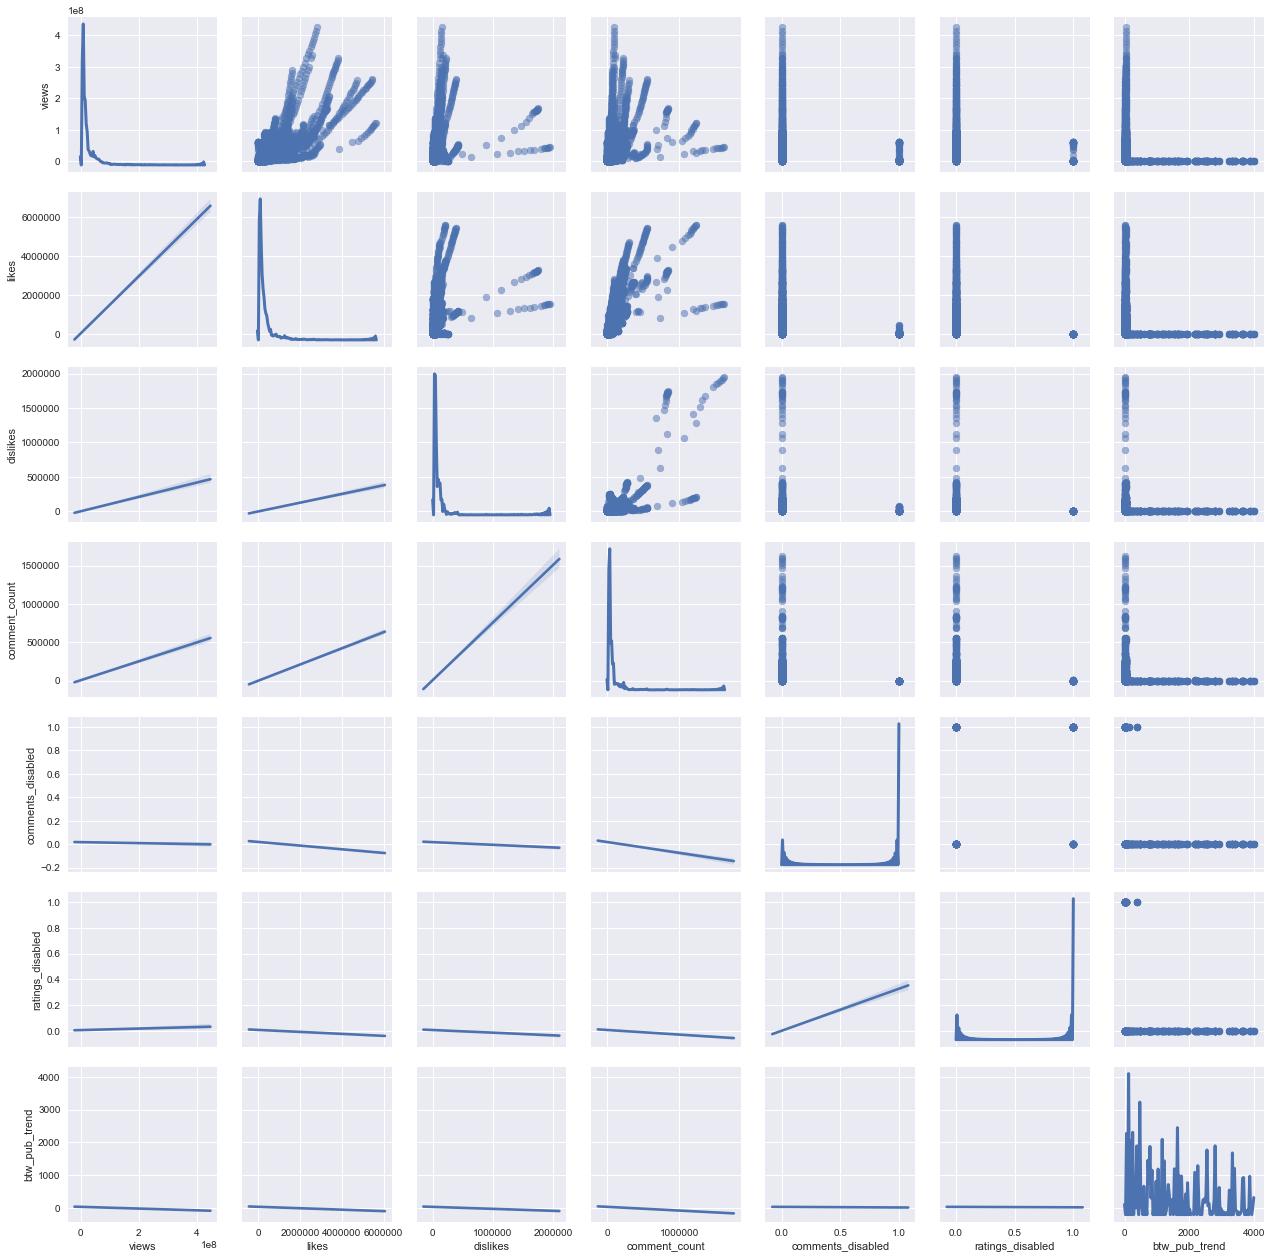

In [185]:
g = sns.PairGrid(df, diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Features correlation with the outcome variable (views) from the scatterplots: 

Posivite correlation (in order of descending correlation): 
1. likes
2. comments 
3. dislikes 

Negative correlation (however, weakly correlated): 
- Days between publising and trending

Other noticeable correlations: 
- Comments and dislikes are very strongly correlated.

### 3.5. Additional Features 

To make our analysis more interesting and to capture some real life interdependancies, we'll also add a few features. Here's the list of features we'll add and explanation why: 

1. Reactions: 'likes' + 'dislikes'. Reactions is engagement without overlap, viewer can only like or dislike a video
2. Total engagement: 'likes' + 'dislikes' + 'comment_count'
3. Sentiment ratio: '(likes' - 'dislikes') / ('likes' + 'dislikes'):  

All these features are about how viewers react to a video. They capture the behavior of users (they like, dislike, comment, ignore), so combinations of them is something we should try building a model.

In [186]:
df['reactions'] = df['likes'] + df['dislikes']
df['total_engagement'] = df['likes'] + df['dislikes'] + df['comment_count']
df['sentiment_ratio'] = (df['likes'] - df['dislikes']) / (df['likes'] + df['dislikes'])

In [193]:
df = df.dropna()

## 4. Regression models to meet research objectives

### 4.1. Factors that contribute the most to the views of the trending videos

In [215]:
X = df.drop(['views', 'publish_date' , 'trending_date', 'channel_title', 'pub_time_str', 'tags'], axis = 1)
Y = df[['views']]

In [216]:
X = pd.get_dummies(X)

#### 4.1.1. OLS Linear model

In [217]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, Y)

score_ols = cross_val_score(regr, X, Y, cv=10)
print("OLS Accuracy: %0.3f (+/- %0.3f)" % (score_ols.mean(), score_ols.std() * 2))

OLS Accuracy: 0.564 (+/- 0.524)


Improving the OLS model: parameters evaluation (p-values): 

In [218]:
import statsmodels.api as sm

lm = sm.OLS(Y, X)
lm = lm.fit()
print('R² for the model:')
print(lm.rsquared)

print(lm.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
plt.scatter(lm.fittedvalues, lm.resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### 4.1.2. Decision Tree

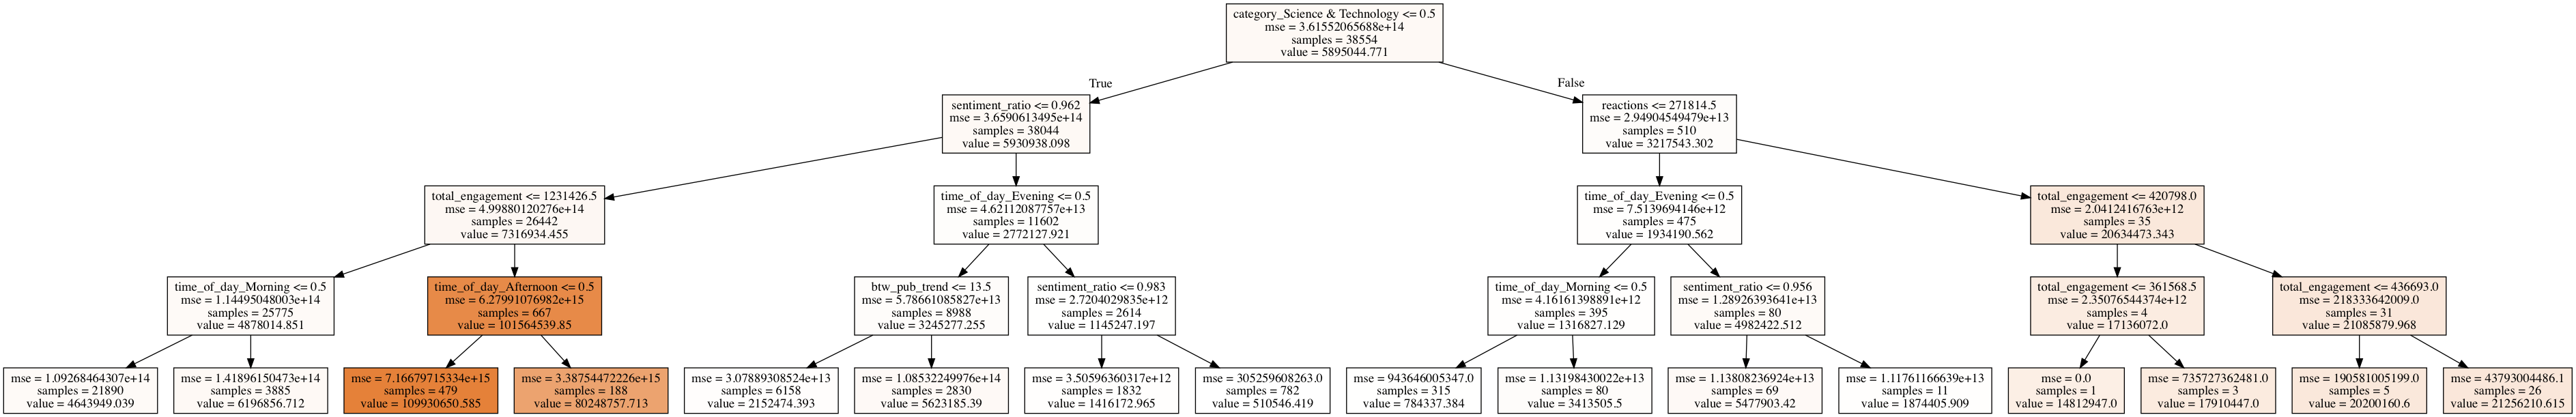

In [233]:
from sklearn import tree
from IPython.display import Image

import pydotplus
import graphviz
#trial run
decision_tree = tree.DecisionTreeRegressor(
    max_features=1,
    max_depth=4,
random_state=2231)
decision_tree.fit(X, Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [234]:
score_dt = cross_val_score(decision_tree, X, Y, cv=10)
print("Decision Tree Accuracy: %0.3f (+/- %0.3f)" % (score_dt.mean(), score_dt.std() * 2))

Decision Tree Accuracy: 0.084 (+/- 0.935)


### 4.2. Build a model to predict number of views

#### 4.2.1. KNeighborsRegressor

In [235]:
from sklearn import neighbors

knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X, Y)

from sklearn.model_selection import cross_val_score

score_knn = cross_val_score(knn_w, X, Y, cv=10)
print("KNN Accuracy: %0.3f (+/- %0.3f)" % (score_knn.mean(), score_knn.std() * 2))

KNN Accuracy: 0.740 (+/- 0.134)


#### 4.2.2. Random Forest 

In [236]:

from sklearn import ensemble
Y_array = Y.values.ravel()
rfc = ensemble.RandomForestRegressor()

score_rfc = cross_val_score(rfc, X, Y_array, cv=10)
print("RFR Accuracy: %0.3f (+/- %0.3f)" % (score_rfc.mean(), score_rfc.std() * 2))

RFR Accuracy: 0.854 (+/- 0.161)


## Runtime measure

In [ ]:
import time
start_time = time.time()
cross_val_score(ensemble.RandomForestRegressor(), X, Y_array, cv=10)
print("Random forest: %.2f seconds" %  (time.time() - start_time))

In [ ]:
start_time = time.time()
cross_val_score(tree.DecisionTreeRegressor(
    max_features=1,
    max_depth=1000,
random_state=400), X, Y, cv=10)
print("Decision tree: %.2f seconds" % (time.time() - start_time))